In [1]:
import numpy as np
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
rc('text', usetex=True)
rc('axes', linewidth=3)

2024-09-23 13:02:38.343361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/benadmin/Projects/George Research/QuantGenMdl/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [3]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

No GPU available. Torch will use CPU.


In [25]:
def image_encode(image_values: np.array, npixels: int):
    norm: float = np.linalg.norm(image_values)
    normalized_image_values: np.array = image_values.flatten()/norm
    return normalized_image_values
    # nqubits = npixels/2
    # qubitvals = []
    # qubitvals.append(normalized_image_values[0] + normalized_image_values[1]) # prob qbit 1 = 0
    # qubitvals.append(normalized_image_values[0] + normalized_image_values[2]) # prob qbit 2 = 0
    
    # statevals = []
    # for i in range(nqubits) {
        # for j in range(nqubits) {
            # statevals = qubitvals[i] * qubitvals[j]
        # }
    # }
    

In [7]:
pixelValues = []
for i in range(4):
    print(i)
    value = 0.33 * i
    pixelValues.append(value)
    print(value)


0
0.0
1
0.33
2
0.66
3
0.99


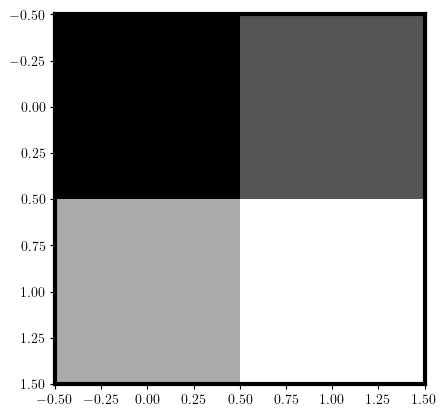

[0.         0.26726124 0.53452248 0.80178373]


In [26]:
values = np.array([pixelValues[0:2], pixelValues[2:4]])
encoded = image_encode(values, 4)
plt.imshow(values, cmap='grey', interpolation='nearest')
plt.show()
print(encoded)

In [29]:
#sanity check
total = 0
for i in encoded:
    total += i**2
total

1.0